# Implementing a KNN classifier
In this notebook, we implement and evaluate a K-nearest-neighbor classification algorithm using the $\mathcal{l}_1$ norm. Unlike the nearest neighbor classifier which only considers the nearest neighbor of a given test point, a KNN classifier is a more regularized classifier that accounts for multiple points in the neighborhood of the test point.

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
from sklearn.metrics import accuracy_score, f1_score

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Spam vs. Non-spam
The data consists of examples of spam and non-spam emails, of which there are 4508 training examples and 93 testing examples. The feature vector $x$ is a 57-dimensional vector extracted from the email and $y = 1$ indicates a spam email. The training and test data has been preprocessed such that the first 54 dimensions of each observation is binary and the last three dimensions are normalized positive numbers.



In [6]:
data_path = os.path.join('data', 'spam')

X_train = pd.read_csv(os.path.join(data_path, 'X_train.csv'), header = None)
X_test = pd.read_csv(os.path.join(data_path, 'X_test.csv'), header = None)
y_train = pd.read_csv(os.path.join(data_path, 'y_train.csv'), header = None)
y_test = pd.read_csv(os.path.join(data_path, 'y_test.csv'), header = None)

# scale the pareto-distributed features
means = X_train.iloc[:, -3:].mean()
stds = X_train.iloc[:, -3:].std()

X_train.iloc[:,-3:] = (X_train.iloc[:,-3:].values - means.values) / stds.values
X_test.iloc[:,-3:] = (X_test.iloc[:,-3:].values - means.values) / stds.values

# KNN Classifier

In [7]:
class KNN_L1_Classifier():
    
    def __init__(self, n_neighbors = 3):
        self.n_neighbors = n_neighbors
        return
        
    def fit(self, X, y):
        self.training_data = X.values
        self.training_labels = y.values
        
        # in case datatype is unsigned
        self.training_data = self.training_data.astype('float')
        
        # in case vector is not one-dimensional
        self.training_labels = self.training_labels.squeeze() 
    
        assert(len(self.training_data.shape) == 2)
        assert(len(self.training_labels.shape) == 1)
        
        return self
        
    def predict(self, X):
        T = X.astype('float').values # T for 'test data'
        X = self.training_data
        
        n_predictions = T.shape[0]
        
        # calculate distance matrix using l1 norm
        distance_matrix = np.zeros([T.shape[0], X.shape[0]])
        for i in range(n_predictions):
            test_vector = T[i, :]
            X_diff = np.abs(X - np.expand_dims(test_vector, axis = 0))
            distance_matrix[i, :] = X_diff.sum(axis = 1).T
        
        # determine the labels of the k nearest neighbors
        indices = np.argsort(distance_matrix, axis = 1)[:,0:self.n_neighbors]
        neighbors = self.training_labels[indices]
        
        # for each test point, predict the majority label of its neighbors
        preds = list()
        for neighbor in neighbors:
            preds.append(np.bincount(neighbor).argmax())
            
        return np.array(preds)

Below we plot the test F1-score as a function of number of neighbors considered.

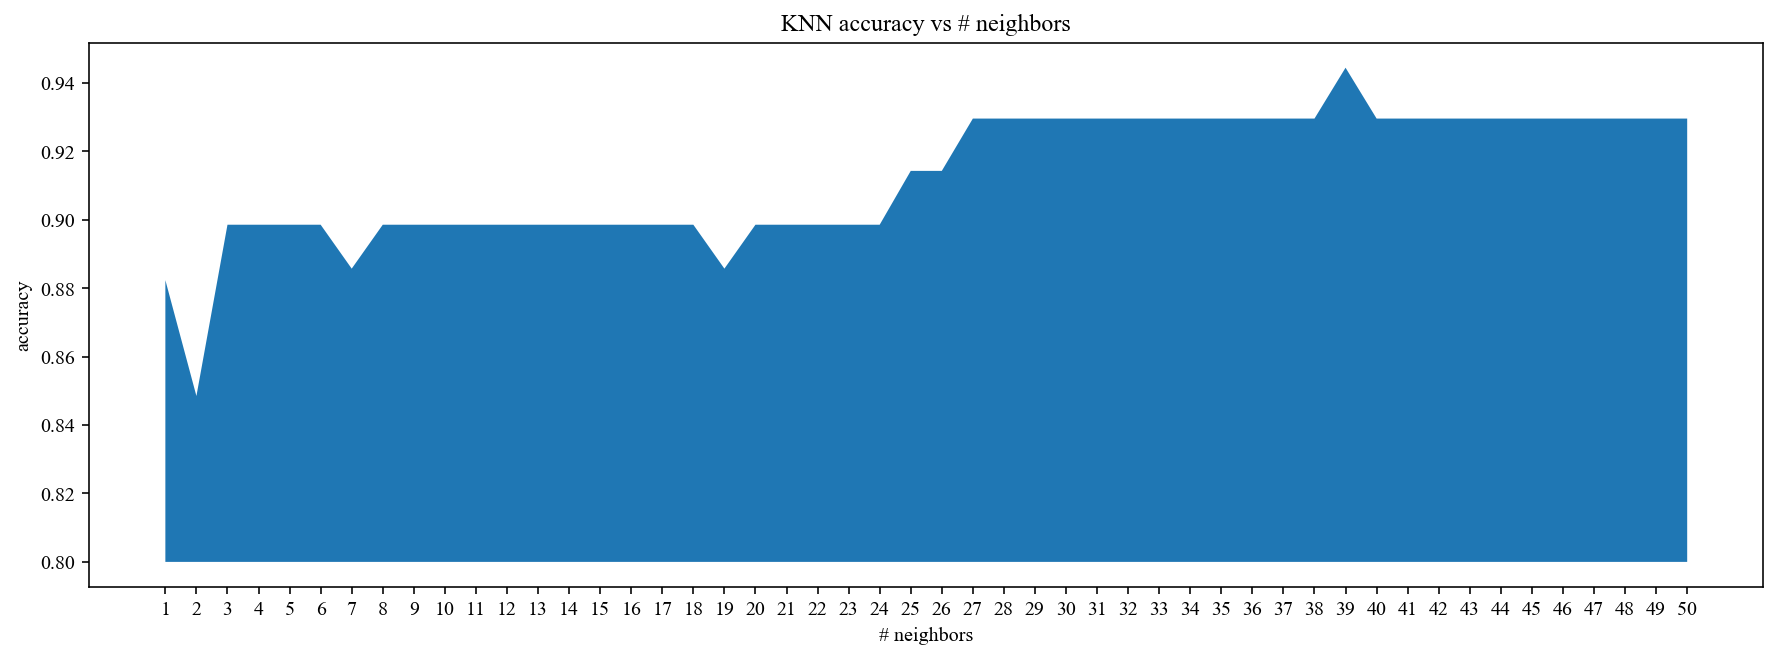

In [13]:
ks = list(range(1, 51))
scores = [f1_score(y_test,
                         KNN_L1_Classifier(k).fit(X_train, y_train).predict(X_test))\
                         for k in ks]

plt.figure(figsize = (15,5))
ax = plt.gca()
ax.fill_between(ks, 0.8, scores)
ax.set(title = 'KNN accuracy vs # neighbors', xlabel = '# neighbors',
       ylabel = 'accuracy', xticks = ks, xticklabels = ks);